In [50]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [51]:
#Read NN and BMS data
n=7;runid=0;function='tanh' #tanh, leaky_ReLU
realization=0
sigma=0.04
NPAR=10 #10, 20
steps=50000

resolution='1x' #'0.5x', '1x', '2x', '4e-3'

test=False

#Read NN data
file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'

model_d='../data/' + resolution + '_resolution/trained_nns/' + file_model
# resolution=='1kx':
#    model_d='../data/' + '1k_points/trained_nns/' + file_model
#else:    
#    model_d='../data/' + resolution + '_resolution/trained_nns/' + file_model

d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)
display(dn)

#Read BMS trace
if resolution=='1x':

    if sigma==0.1:
            filename='BMS_'+function+'_n_'+str(n)+'_sigma_0.10_r_' + str(realization) + '_res_0.05_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
    else:
            filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_res_0.05_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'

    if test==False:
        trace=pd.read_csv('../data/MSTraces/' + resolution + '_resolution/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
    elif test==True:
        trace=pd.read_csv('../data/MSTraces/' + 'test/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
    
elif resolution=='0.5x':
    if sigma==0.1:
            filename='BMS_'+function+'_n_'+str(n)+'_sigma_0.10_r_' + str(realization) + '_res_0.1_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
    else:
            filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_res_0.1_trace_'+str(steps)+'_prior_'+str(NPAR) + '.csv'

elif resolution=='2x':
    if sigma==0.1:
            filename='BMS_'+function+'_n_'+str(n)+'_sigma_0.1_r_' + str(realization) + '_res_0.025_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
    else:
            filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_res_0.025_trace_'+str(steps)+'_prior_'+str(NPAR) + '.csv'
    
    trace=pd.read_csv('../data/MSTraces/' + resolution + '_resolution/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])


,x1,y,rep,noise,y_noise,ymodel
0,-1.95,0.000742,7.0,0.025489,0.026230,0.007131
1,-1.90,0.000555,7.0,-0.034723,-0.034169,0.004925
2,-1.85,0.000384,7.0,-0.016451,-0.016067,0.002897
3,-1.80,0.000236,7.0,-0.024604,-0.024368,0.001060
4,-1.75,0.000117,7.0,0.038539,0.038655,-0.000569
...,...,...,...,...,...,...
75,1.80,0.128330,7.0,0.031789,0.160118,0.110179
76,1.85,0.132584,7.0,0.008559,0.141143,0.110721
77,1.90,0.137246,7.0,-0.008202,0.129044,0.111254
78,1.95,0.142347,7.0,0.064814,0.207161,0.111775


In [52]:
#Parameters to read models
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()


if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

In [53]:
#Minimum description length model
y=dn.y_noise

minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

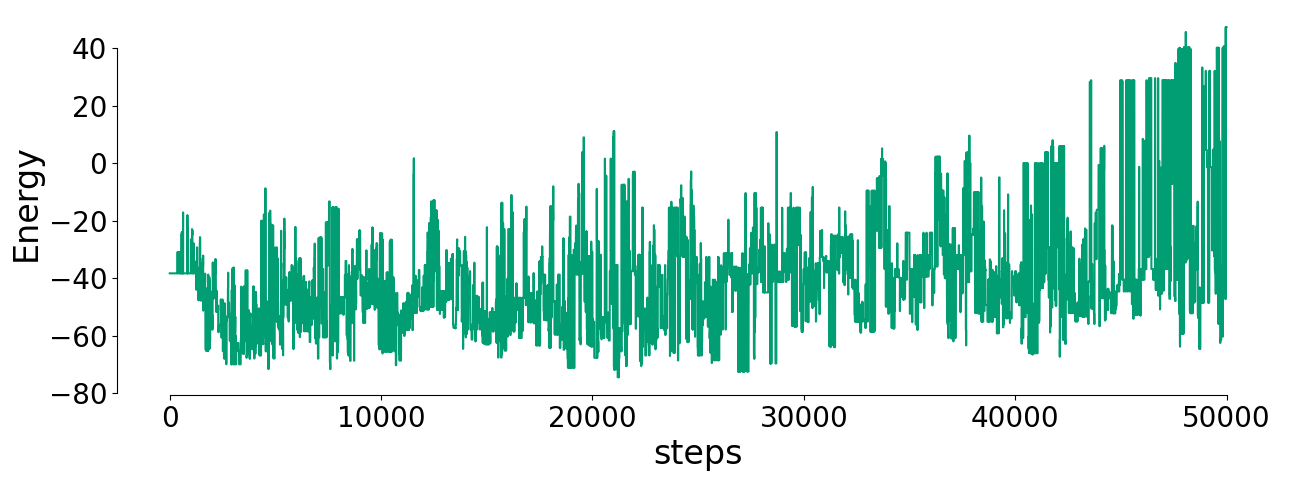

In [56]:
Nini = 00
plt.figure(figsize=(15, 5))


color_data=sns.color_palette("colorblind")[0]
color_noise=sns.color_palette("colorblind")[7]
color_ann=sns.color_palette("colorblind")[4]
color_bms=sns.color_palette("colorblind")[2]

#Define figure size in cm                                                                           
Extensions=['.svg']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                           
#plt.title(str(function) + ', ' + 'n=' + str(n) +', r=' + str(realization))
plt.plot(trace.t[trace.t > Nini], trace.H[trace.t > Nini], color=color_bms)
plt.xticks(fontsize=20);plt.yticks(fontsize=20)
plt.xlabel('steps',fontsize=24);plt.ylabel('Energy',fontsize=24)
#plt.scatter(minrow['t'], minH,color='r')
sns.despine(trim=True)

Name_figure='Energy_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

for ext in Extensions:
        plt.savefig('../results/' + Name_figure + ext,dpi=300)

 
plt.show()

80
50
60


,x1,y,rep,noise,y_noise,ymodel,ybms
49,0.50,0.121220,7.0,-0.024446,0.096774,0.105522,0.107307
50,0.55,0.117053,7.0,-0.033271,0.083782,0.100395,0.098587
51,0.60,0.113561,7.0,0.034194,0.147755,0.096550,0.090666
52,0.65,0.110631,7.0,0.027672,0.138303,0.093775,0.083482
53,0.70,0.108179,7.0,-0.014284,0.093895,0.091878,0.076973
54,0.75,0.106142,7.0,-0.049234,0.056908,0.090688,0.071081
55,0.80,0.104473,7.0,-0.009949,0.094524,0.090060,0.065748
56,0.85,0.103137,7.0,0.033888,0.137025,0.089874,0.060923
57,0.90,0.102107,7.0,-0.057995,0.044112,0.090029,0.056555
58,0.95,0.101365,7.0,-0.001894,0.099471,0.090444,0.052600


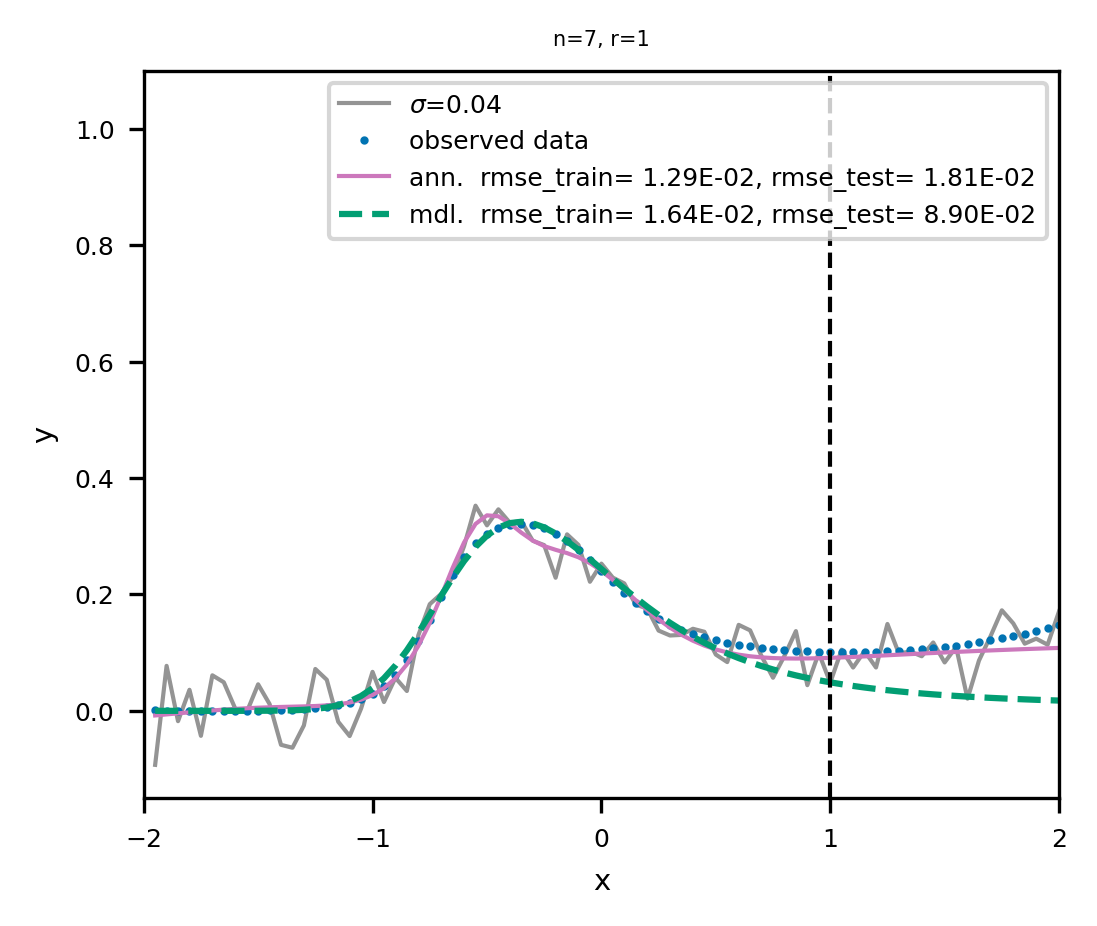

In [49]:
#Plot

#Validation and train borders
n_points=int(len(dn.index))
print(n_points)
train_fraction=5/8;valid_fraction=1/8;test_fraction=0.2
train_size_ann=int(n_points*train_fraction)
train_size_bms=train_size_ann + int(n_points*valid_fraction)
print(train_size_ann)
print(train_size_bms)


train_border=dn.loc[train_size_bms-1]['x1']

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)
#dplot['ybms'] = 0*len(dplot)
display(dplot.loc[train_size_ann-1:])

#ann errors
rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size_bms-1]['ymodel'],dplot.loc[:train_size_bms -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size_bms-1:]['ymodel'],dplot.loc[train_size_bms -1:]['y'])
#rmse_nn_validation=root_mean_squared_error(dplot.iloc[validation_points]['ymodel'],dplot.iloc[validation_points]['y'])

#bms errors
rmse_mdl=root_mean_squared_error(dplot.ybms,dn.y)
rmse_mdl_train=root_mean_squared_error(dplot.loc[:train_size_bms-1]['ybms'],dn.loc[:train_size_bms-1]['y'])
rmse_mdl_test =root_mean_squared_error(dplot.loc[train_size_bms-1:]['ybms'],dn.loc[train_size_bms-1:]['y'])

 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)           

#colors from seaborn's colorblind palette
color_data=sns.color_palette("colorblind")[0]
color_noise=sns.color_palette("colorblind")[7]
color_ann=sns.color_palette("colorblind")[4]
color_bms=sns.color_palette("colorblind")[2]
color_valid_ann=sns.color_palette("colorblind")[8]

#Separate train and validation set for plot
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#validation_points=[11,31,35,42,43,44,76,83,85,95,98,109,116,122,128,138,140,145,151,154,155,156, 159, 160, 166, 169, 170, 176, 181, 186,
#187,191,202,203,205,220,222,223,225,235,242,243,247,248,254,273,279,282,284,288,293,294,298,307,312,319,325,342,346,352,355,356,362,364,372,
#378,380,388,389,398,423,435,442,449,456,457,463,469,470,474,482,490,496,501,516,518,523,534,539,542,544,565,575,578,584,590,599,608,609,610,
#611,614,619,622,626,627,635,646,650,653,654,657,661,671,674,677,679,688,689,699,703,718,719,720,746]
#dn_validation=dn.iloc[validation_points]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color=color_noise,label=r'$\sigma$=' + str(sigma) )
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color=color_data,label='observed data') 
plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color=color_ann, label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test))

#plt.plot(dn_validation['x1'], dn_validation['ymodel'], '.',markersize=1,color=color_valid_ann, label='ann.  new validation rmse=%.2E' % rmse_nn_validation)
plt.plot(dplot.x1, dplot.ybms, color=color_bms, linestyle='--',label='mdl.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_mdl_train, rmse_mdl_test)) 
                                                                                

#plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color=color_ann)
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title('n=%d, r=%d' % (n, realization),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2,2);plt.ylim(-0.15,1.1)  

if test==False:
    Name_figure='Prediction_' + resolution + '_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)
elif test==True:
     Name_figure='Prediction_test' + resolution + '_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()